trying to make something like: www.lyingforjesus.org/Bible-Contradictions

bible source used : www.gutenberg.org/ebooks/10.txt.utf-8

In [1]:
%matplotlib notebook

In [2]:
import re
import numpy as np
import urllib.request
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from itertools import combinations

In [3]:
bible_full = urllib.request.urlopen("https://www.gutenberg.org/ebooks/10.txt.utf-8")

bible_lines = [line.decode("utf-8").strip() for line in bible_full][23:]
bible_lines = list(filter(None, bible_lines))
bible_lines = [line.replace("  ", " ") for line in bible_lines]

In [4]:
rep = True
while rep:
  rep = False
  for indx,line in enumerate(bible_lines):
    if "Called:" in line:
      print(line, bible_lines[indx+1])
      del bible_lines[indx : indx+2]
      rep = True
      break

Otherwise Called: The First Book of the Kings
Otherwise Called: The Second Book of the Kings
Commonly Called: The Third Book of the Kings
Commonly Called: The Fourth Book of the Kings


### separate titles and content

In [5]:
OT_book_titles = bible_lines[1:40]
NT_book_titles = bible_lines[41:68]
bible_lines = bible_lines[68:]

# create a dict of short titles
titles_short = { title : title.split()[-1] for title in OT_book_titles+NT_book_titles}
title_parts = ['Samuel', 'Kings', 'Chronicles', 'Corinthians', 'Thessalonians', 'Timothy', 'Peter', 'John']
for title, title_short in titles_short.items() :
  if ('First' in title) and (title_short in title_parts):
    titles_short[title] = f'1 {title_short}'
  elif ('Second' in title) and (title_short in title_parts):
    titles_short[title] = f'2 {title_short}'
  elif ('Third' in title) and (title_short in title_parts):
    titles_short[title] = f'3 {title_short}'  
titles_short['The Lamentations of Jeremiah'] = 'Lamentations'
titles_short['The Revelation of Saint John the Divine'] = 'Revelation'
titles_short['The Acts of the Apostles'] = 'Acts'

# for title, title_short in titles_short.items() : print(f'{title} : {title_short}')

# for title in OT_book_titles:
#   print(titles_short[title])
# for title in NT_book_titles:
#   print(titles_short[title])

In [6]:
# create empty book dicts
OT_books = dict.fromkeys(OT_book_titles, None)
NT_books = dict.fromkeys(NT_book_titles, None)

# fill book dicts
def fill_books(book_dict):
  book_names = list(book_dict.keys())
  for indx in range(len(book_names)-1):
    book_name = book_names[indx]
    next_book_name = book_names[indx + 1]

    book_start = bible_lines.index(book_name) + 1
    book_end   = bible_lines.index(next_book_name, book_start)

    book_dict[book_name] = bible_lines[book_start : book_end]
  # add last book
  book_name = book_names[-1]
  book_start = bible_lines.index(book_name)
  try:
    book_end = bible_lines.index('***', book_start)
  except ValueError:
    book_end = bible_lines.index('*** END OF THE PROJECT GUTENBERG EBOOK THE KING JAMES BIBLE ***', book_start)
  book_dict[book_name] = bible_lines[book_start : book_end]

fill_books(OT_books)
fill_books(NT_books)

In [7]:
# break books into chapters and verses
def break_books(books):
  new_books = {}
  for book_name, book in tqdm(books.items()):
    book_full = ' '.join(book)
    chapvers = re.findall('[0-9]+:[0-9]+', book_full)

    chaps = []; verses = []
    curr_chap = '1'
    for indx in range(len(chapvers)-1):
      chapver = chapvers[indx]
      next_chapver = chapvers[indx + 1]
      chap, vers = chapver.split(':')

      if chap != curr_chap:
        chaps.append(verses)
        verses = []
        curr_chap = chap

      vers_start = book_full.index(chapver) + len(chapver) + 1
      vers_end = book_full.index(next_chapver, vers_start) - 1
      verse = book_full[vers_start : vers_end]
      verses.append(verse)

    # add last verse
    chapver = chapvers[-1]
    chap, vers = chapver.split(':')
    if chap != curr_chap:
        chaps.append(verses)
        verses = []
    vers_start = book_full.index(chapver) + len(chapver) + 1
    verse = book_full[vers_start : ]
    verses.append(verse)
    chaps.append(verses)

    new_books[book_name] = chaps
  return new_books  

OT_books = break_books(OT_books)
NT_books = break_books(NT_books)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

In [8]:
# confirm total verses
# OT : 23145
# NT : 7957

OT_total_verses = sum([len(chap) for book in OT_books.values() for chap in book])
NT_total_verses = sum([len(chap) for book in NT_books.values() for chap in book])
print(f'OT : {OT_total_verses} \nNT : {NT_total_verses}')

OT : 23145 
NT : 7957


In [9]:
def search_bible(word):
  results = []
  # search OT
  for book_name, book in OT_books.items():
    for chap_num, chap in enumerate(book):
      for verse_num, verse in enumerate(chap):
        if word in verse:
          #results.append(f'OT_books["{book_name}"][{chap_num}][{verse_num}]')
          results.append(('OT', book_name, chap_num, verse_num))

  # search NT
  for book_name, book in NT_books.items():
    for chap_num, chap in enumerate(book):
      for verse_num, verse in enumerate(chap):
        if word in verse:
          #results.append(f'NT_books["{book_name}"][{chap_num}][{verse_num}]')
          results.append(('NT', book_name, chap_num, verse_num))
  return results        

In [10]:
def make_arcs(arcs, axs, active=None):
  theta = np.linspace( 0 , np.pi , 150 )
  
  for indx, (center, radius, colr) in enumerate(arcs): 
    a = center + radius * np.cos(theta)
    b = radius * np.sin(theta)
    if active is not None:
      alpha = 1.0 if indx == active else 0.1
    else:
      alpha = 1.0  
    axs.plot(a,b, c=colr, alpha=alpha)

def get_pos(v_test, v_book, v_chap, v_verse):
  books = OT_books if v_test == 'OT' else NT_books
  v_pos = v_verse

  for book_name, book in books.items():
    if book_name == v_book:
      break
    v_pos += sum([len(chap) for chap in book])
  if v_test == 'NT':
    v_pos += OT_total_verses
  return v_pos  

def get_arcs(results):
  arcs = []
  for indx in range(len(results)-1):
    v1, v2 = results[indx], results[indx+1]

    v1_test, v1_book, v1_chap, v1_verse = v1
    v2_test, v2_book, v2_chap, v2_verse = v2

    v1_pos = get_pos(v1_test, v1_book, v1_chap, v1_verse)
    v2_pos = get_pos(v2_test, v2_book, v2_chap, v2_verse)

    if v1_test != v2_test: colr='g'
    elif v1_test == 'OT': colr='r'
    elif v1_test == 'NT': colr='b'

    theta = np.linspace( 0 , np.pi , 150 )
    radius = abs(v1_pos - v2_pos)/2
    center = (v1_pos + v2_pos)/2

    arcs.append((center, radius, colr))
  return arcs  
    
def print_all(results):
  for verse in results:
    v_test, v_book, v_chap, v_verse = verse
    books = OT_books if v_test == 'OT' else NT_books
    v_pos = get_pos(v_test, v_book, v_chap, v_verse)

    print(f'{v_test} -> {titles_short[v_book] if v_book in titles_short else v_book} {v_chap+1}:{v_verse+1}')
    print(books[v_book][v_chap][v_verse])
    # print(f'v_pos = {v_pos}')
    print()
    
def plot_all(results, axs):
  if len(results) <= 100:
    arcs = get_arcs(results)
    make_arcs(arcs, axs)
  else:
    print("more than 100 arcs")
  return None

In [11]:
def onclick(event):
  x, y = event.xdata, event.ydata
  dists = []

  for indx, (center, radius, colr) in enumerate(arcs):
    dist = ((x-center)**2 + y**2)**0.5
    dists.append(dist/radius)
    
    if abs(dist/radius - 1) < 0.05:
      axs.cla()  
      if active[0] != indx:
        active[0] = indx
      
      v1_test, v1_book, v1_chap, v1_verse = results[indx]
      v2_test, v2_book, v2_chap, v2_verse = results[indx + 1]
      v1_book = titles_short[v1_book] if v1_book in titles_short else v1_book
      v2_book = titles_short[v2_book] if v2_book in titles_short else v2_book
    
      result = f'{v1_test}\n{v1_book}\n{v1_chap+1}:{v1_verse+1}'
      axs.text(x,y,result)
      result = f'{v2_test:>30}\n{v2_book:>30}\n{v2_chap+1:>30}:{v2_verse+1}'
      axs.text(x,y,result)
    
      make_arcs(arcs, axs, active[0])
      break  
  else:
    if active[0] != None:
      active[0] = None
      axs.cla()
      #axs.text(x,y,min(dists))
      make_arcs(arcs, axs, active[0])

In [12]:
results = search_bible('forgiveness')
print(len(results))

8


<IPython.core.display.Javascript object>


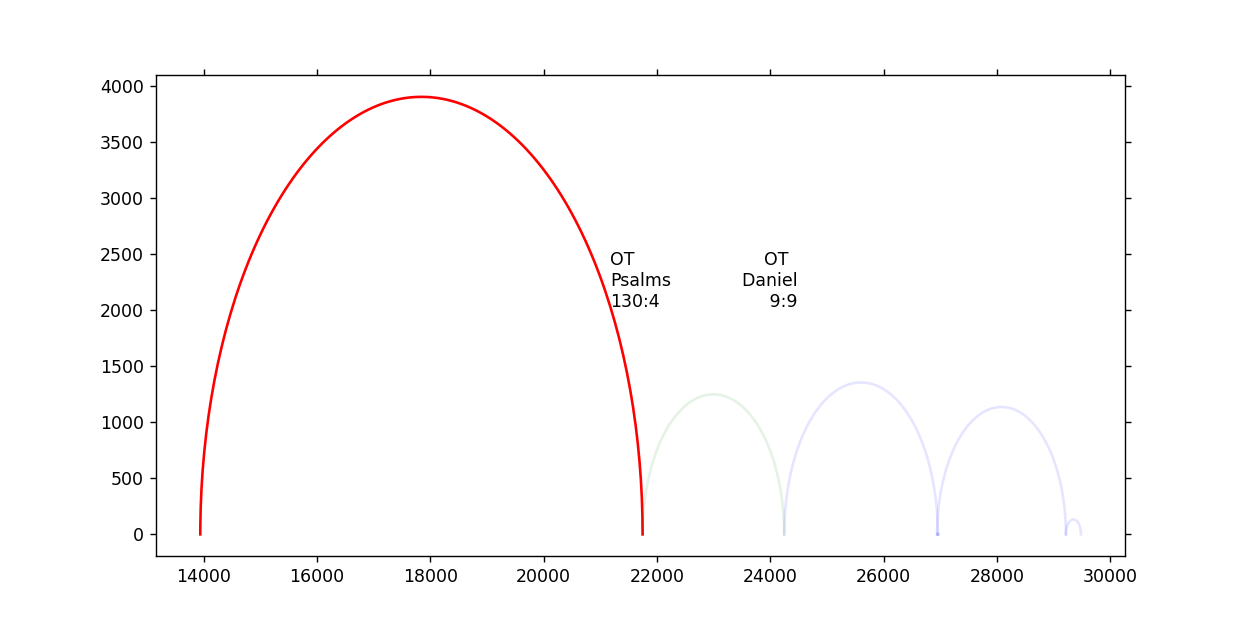

In [13]:
fig, axs = plt.subplots(figsize=(10,5))
plot_all(results, axs)
arcs = get_arcs(results)
active = [None]

fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()

In [62]:
print_all(results)

OT -> Psalms 130:4
But there is forgiveness with thee, that thou mayest be feared.

OT -> Daniel 9:9
To the Lord our God belong mercies and forgivenesses, though we have rebelled against him;

NT -> Mark 3:29
But he that shall blaspheme against the Holy Ghost hath never forgiveness, but is in danger of eternal damnation.

NT -> Acts 5:31
Him hath God exalted with his right hand to be a Prince and a Saviour, for to give repentance to Israel, and forgiveness of sins.

NT -> Acts 13:38
Be it known unto you therefore, men and brethren, that through this man is preached unto you the forgiveness of sins:

NT -> Acts 26:18
To open their eyes, and to turn them from darkness to light, and from the power of Satan unto God, that they may receive forgiveness of sins, and inheritance among them which are sanctified by faith that is in me.

NT -> Ephesians 1:7
In whom we have redemption through his blood, the forgiveness of sins, according to the riches of his grace;

NT -> Colossians 1:14
In whom w